<a href="https://colab.research.google.com/github/RATFIVE/GEOMAR-DeepLearning/blob/main/app/backend/small-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [8]:
!git clone https://github.com/RATFIVE/GEOMAR-DeepLearning.git
%cd GEOMAR-DeepLearning/app/backend

Cloning into 'GEOMAR-DeepLearning'...
remote: Enumerating objects: 306, done.
remote: Counting objects: 100% (306/306), done.
remote: Compressing objects: 100% (148/148), done.
remote: Total 306 (delta 162), reused 239 (delta 106), pack-reused 0 (from 0)
Receiving objects: 100% (306/306), 5.11 MiB | 21.37 MiB/s, done.
Resolving deltas: 100% (162/162), done.
/content/GEOMAR-DeepLearning/GEOMAR-DeepLearning/app/backend


In [10]:
!pip install copernicusmarine

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 5.7 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=3cc2e126cd58cd1a4692cca8500feeb45503246c4b863083f27c97236c88651a
  Stored in directory: /root/.cache/pip/wheels/71/c1/da/23077eb3b87d24d6f3852ed1ed1a1ac2d3c885ad6ebd2b4a07
Successfully built asciitree


In [11]:
!pip freeze > requirements.txt

In [9]:
# import all necessary libraries
import copy
import os
from PIL import Image
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import datetime
from utils.Copernicus import AdvancedCopernicus




# Display all columns
pd.options.display.max_columns = None
pd.options.display.max_rows = None

ModuleNotFoundError: No module named 'copernicusmarine'

In [ ]:
START_DATE = '2025-02-01'
END_DATE = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
OUTPUT_FILENAME = 'output.nc'

BBOX= {
    # "min_lon":10.038345850696412,
    # "max_lon":10.365962458698567,
    # "min_lat":54.27381478077755,
    # "max_lat":54.52976525577923,

    "minimum_longitude":9.85083510071235,
    "maximum_longitude":10.926709174713364,
    "minimum_latitude":54.25206332481298,
    "maximum_latitude":54.97306793985031,

    "target_min_lon":10.156,
    "target_max_lon":10.170,
    "target_min_lat":54.354,
    "target_max_lat":54.365
    }

In [ ]:
copernicus = AdvancedCopernicus()
def load_ocean_data(variables=["bottomT", "mlotst", "siconc", "sithick", "sla", "so", "sob", "thetao", "uo", "vo", "wo"],
                    minimum_longitude=BBOX["minimum_longitude"],
                    maximum_longitude=BBOX["maximum_longitude"],
                    minimum_latitude=BBOX["minimum_latitude"],
                    maximum_latitude=BBOX["maximum_latitude"]):

    data = copernicus.get_subset(
        dataset_id="cmems_mod_bal_phy_anfc_PT1H-i",
        dataset_version="202411",
        variables=variables,
        minimum_longitude=minimum_longitude,
        maximum_longitude=maximum_longitude,
        minimum_latitude=minimum_latitude,
        maximum_latitude=maximum_latitude,
        start_datetime=START_DATE,
        end_datetime=END_DATE,
        minimum_depth=0.5016462206840515,
        maximum_depth=0.5016462206840515,
        coordinates_selection_method="strict-inside",
        disable_progress_bar=False,
        output_filename=OUTPUT_FILENAME)

    return data.to_dataframe().reset_index()

training_data = load_ocean_data(
    variables=["bottomT", "mlotst", "siconc", "sithick", "sla", "so", "sob", "thetao", "uo", "vo", "wo"],
    minimum_longitude=BBOX["minimum_longitude"],
    maximum_longitude=BBOX["maximum_longitude"],
    minimum_latitude=BBOX["minimum_latitude"],
    maximum_latitude=BBOX["maximum_latitude"]
)

target_data = load_ocean_data(
    variables=["sla"],
    minimum_longitude=BBOX["target_min_lon"],
    maximum_longitude=BBOX["target_max_lon"],
    minimum_latitude=BBOX["target_min_lat"],
    maximum_latitude=BBOX["target_max_lat"]
)

INFO - 2025-02-26T10:05:09Z - Selected dataset version: "202411"
INFO - 2025-02-26T10:05:09Z - Selected dataset part: "default"
INFO - 2025-02-26T10:05:14Z - Starting download. Please wait...


  0%|          | 0/330 [00:00<?, ?it/s]

INFO - 2025-02-26T10:05:36Z - Successfully downloaded to output.nc
INFO - 2025-02-26T10:05:38Z - Selected dataset version: "202411"
INFO - 2025-02-26T10:05:38Z - Selected dataset part: "default"
INFO - 2025-02-26T10:05:42Z - Starting download. Please wait...


  0%|          | 0/2 [00:00<?, ?it/s]

INFO - 2025-02-26T10:05:42Z - Successfully downloaded to output.nc


## IDA

In [ ]:
def process_df(df):
    df = df.dropna(axis=1, how="all")
    df = df.dropna(axis=0, how="any")
    df = df[["time"] + [col for col in df.columns if col != "time"]]
    float_cols = df.select_dtypes(include=["float"]).columns
    df[float_cols] = df[float_cols].astype(np.float32)
    df["time"] = pd.to_datetime(df["time"]).dt.tz_localize(None).dt.round("h")
    df = df.reset_index(drop=True)
    return df

In [ ]:
training_data = process_df(training_data)
display(training_data.head(3))
display(training_data.info())

,time,depth,latitude,longitude,bottomT,mlotst,siconc,sithick,sla,so,sob,thetao,uo,vo,wo
0,2025-02-01 00:00:00,0.501646,54.308277,10.708242,3.949874,11.431097,0.0,0.0,-0.094585,20.076197,20.076197,3.949874,0.0,-0.003346,-1.130791e-06
1,2025-02-01 01:00:00,0.501646,54.308277,10.708242,3.947661,11.449051,0.0,0.0,-0.076631,20.077806,20.077806,3.947661,0.0,-0.004077,-7.328313e-07
2,2025-02-01 02:00:00,0.501646,54.308277,10.708242,3.945188,11.472710,0.0,0.0,-0.052973,20.080185,20.080185,3.945187,0.0,-0.007542,-3.588450e-07


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654228 entries, 0 to 654227
Data columns (total 15 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   time       654228 non-null  datetime64[ns]
 1   depth      654228 non-null  float32       
 2   latitude   654228 non-null  float32       
 3   longitude  654228 non-null  float32       
 4   bottomT    654228 non-null  float32       
 5   mlotst     654228 non-null  float32       
 6   siconc     654228 non-null  float32       
 7   sithick    654228 non-null  float32       
 8   sla        654228 non-null  float32       
 9   so         654228 non-null  float32       
 10  sob        654228 non-null  float32       
 11  thetao     654228 non-null  float32       
 12  uo         654228 non-null  float32       
 13  vo         654228 non-null  float32       
 14  wo         654228 non-null  float32       
dtypes: datetime64[ns](1), float32(14)
memory usage: 39.9 MB


None

In [ ]:
target_data = process_df(target_data)
target_data.groupby(by=["time", 'latitude', 'longitude']).mean()
display(target_data.head(3))
display(target_data.info())
display(target_data['latitude'].unique())

,time,latitude,longitude,sla
0,2025-02-01 00:00:00,54.358276,10.152689,-0.120450
1,2025-02-01 01:00:00,54.358276,10.152689,-0.091966
2,2025-02-01 02:00:00,54.358276,10.152689,-0.065222


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time       612 non-null    datetime64[ns]
 1   latitude   612 non-null    float32       
 2   longitude  612 non-null    float32       
 3   sla        612 non-null    float32       
dtypes: datetime64[ns](1), float32(3)
memory usage: 12.1 KB


None

array([54.358276], dtype=float32)

In [ ]:
df_merged = pd.merge(training_data, target_data, on="time", how="inner", suffixes=("", "_target"))
display(df_merged.head(3))
display(df_merged.info())
display(df_merged.describe())

,time,depth,latitude,longitude,bottomT,mlotst,siconc,sithick,sla,so,sob,thetao,uo,vo,wo,latitude_target,longitude_target,sla_target
0,2025-02-01 00:00:00,0.501646,54.308277,10.708242,3.949874,11.431097,0.0,0.0,-0.094585,20.076197,20.076197,3.949874,0.0,-0.003346,-1.130791e-06,54.358276,10.152689,-0.120450
1,2025-02-01 01:00:00,0.501646,54.308277,10.708242,3.947661,11.449051,0.0,0.0,-0.076631,20.077806,20.077806,3.947661,0.0,-0.004077,-7.328313e-07,54.358276,10.152689,-0.091966
2,2025-02-01 02:00:00,0.501646,54.308277,10.708242,3.945188,11.472710,0.0,0.0,-0.052973,20.080185,20.080185,3.945187,0.0,-0.007542,-3.588450e-07,54.358276,10.152689,-0.065222


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654228 entries, 0 to 654227
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   time              654228 non-null  datetime64[ns]
 1   depth             654228 non-null  float32       
 2   latitude          654228 non-null  float32       
 3   longitude         654228 non-null  float32       
 4   bottomT           654228 non-null  float32       
 5   mlotst            654228 non-null  float32       
 6   siconc            654228 non-null  float32       
 7   sithick           654228 non-null  float32       
 8   sla               654228 non-null  float32       
 9   so                654228 non-null  float32       
 10  sob               654228 non-null  float32       
 11  thetao            654228 non-null  float32       
 12  uo                654228 non-null  float32       
 13  vo                654228 non-null  float32       
 14  wo  

None

,time,depth,latitude,longitude,bottomT,mlotst,siconc,sithick,sla,so,sob,thetao,uo,vo,wo,latitude_target,longitude_target,sla_target
count,654228,654228.000000,654228.000000,654228.000000,654228.000000,654228.000000,6.542280e+05,6.542280e+05,654228.000000,654228.000000,654228.000000,654228.000000,654228.000000,654228.000000,6.542280e+05,654228.000000,654228.000000,654228.000000
mean,2025-02-13 17:29:59.999999488,0.501646,54.660526,10.454244,3.945716,10.478156,3.857553e-08,3.301091e-07,-0.212824,15.357598,19.258955,3.309731,-0.030445,0.058961,-3.121308e-07,54.358334,10.152695,-0.218330
min,2025-02-01 00:00:00,0.501646,54.308277,9.874912,-0.591978,2.274687,0.000000e+00,0.000000e+00,-0.921992,8.571222,8.571222,-0.799094,-0.898166,-1.230932,-2.172987e-04,54.358276,10.152689,-0.816700
25%,2025-02-07 08:45:00,0.501646,54.524940,10.208244,3.520014,9.892264,0.000000e+00,0.000000e+00,-0.381543,13.245098,18.903009,2.928122,-0.080718,-0.020173,2.117468e-09,54.358276,10.152689,-0.408307
50%,2025-02-13 17:30:00,0.501646,54.658272,10.458243,3.900797,10.019227,0.000000e+00,0.000000e+00,-0.198689,15.670680,19.688978,3.370786,-0.016336,0.024034,3.911743e-07,54.358276,10.152689,-0.203597
75%,2025-02-20 02:15:00,0.501646,54.791603,10.680465,4.450780,10.158411,0.000000e+00,0.000000e+00,-0.040329,17.822624,20.384881,3.773287,0.028923,0.090586,1.470732e-06,54.358276,10.152689,-0.030002
max,2025-02-26 11:00:00,0.501646,54.958267,10.902686,7.357439,33.155102,1.039391e-02,9.997947e-02,0.236108,20.839090,23.257256,4.939826,0.761376,1.805505,5.789600e-05,54.358276,10.152689,0.213716
std,NaN,0.000000,0.166514,0.276905,0.732617,2.844389,1.898714e-05,1.757113e-04,0.212262,2.953536,2.154766,0.640052,0.119572,0.178992,9.967143e-06,0.000000,0.000000,0.228352


## EDA

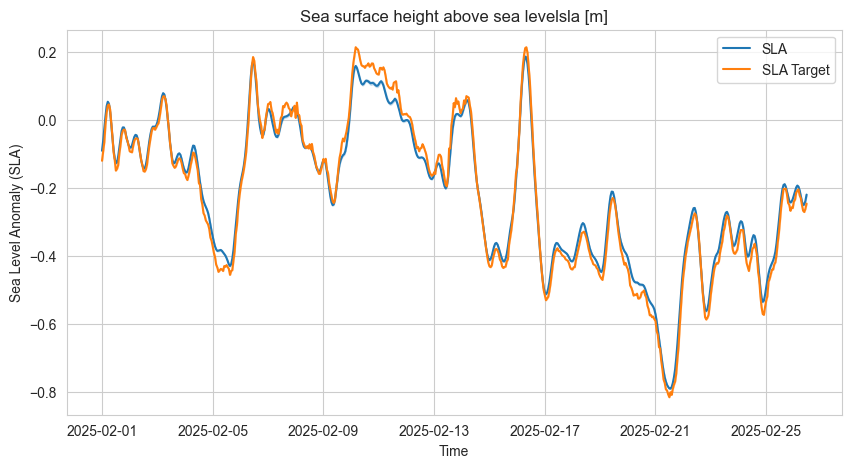

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for Seaborn
sns.set_style("whitegrid")

# Erstellen der Plot-Figur
plt.figure(figsize=(10, 5))

# Plot der SLA-Daten
sns.lineplot(x=df_merged["time"], y=df_merged["sla"], label="SLA")

# Plot der SLA Target-Daten
sns.lineplot(x=df_merged["time"], y=df_merged["sla_target"], label="SLA Target")

# Achsen und Titel setzen
plt.title("Sea surface height above sea levelsla [m]")
plt.xlabel("Time")
plt.ylabel("Sea Level Anomaly (SLA)")

# Legende anzeigen
plt.legend()

# Diagramm anzeigen
plt.show()


# Stationary

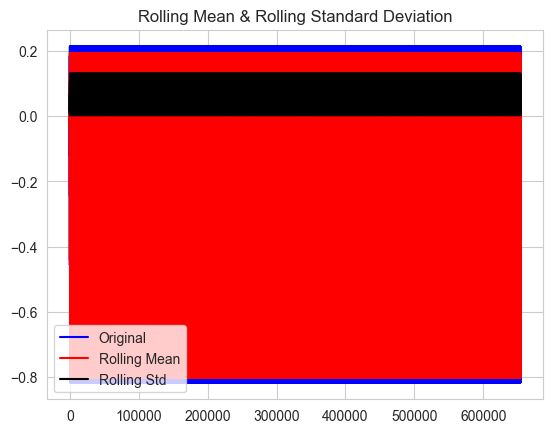

In [ ]:
df_target = df_merged["sla_target"]

rolling_mean = df_target.rolling(window = 7).mean(numeric_only=True)
rolling_std = df_target.rolling(window = 7).std(numeric_only=True)
plt.plot(df_target, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [ ]:

from statsmodels.tsa.stattools import adfuller
def print_df_stats(series, order):
    x=series
    if (order>0):
        x=x.diff(order)[order:]
    result = adfuller(x)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

print_df_stats(df_target, 0)
print_df_stats(df_target, 1)

In [ ]:
# from statsmodels.tsa.stattools import acf, pacf

# diff_series=df_target.diff(2)[2:]

# lag_acf=acf(diff_series, nlags=7)
# lag_pacf=pacf(diff_series, nlags=7, method='ols')
# plt.figure(figsize=(20,10))
# plt.subplot(121)
# plt.plot(lag_acf)
# plt.axhline(y=0,linestyle='--',color='green')
# plt.axhline(y=-1.96/np.sqrt(len(diff_series)),linestyle='--',color='green')
# plt.axhline(y=1.96/np.sqrt(len(diff_series)),linestyle='--',color='green')
# plt.title('Autocorrelation Function')
# plt.subplot(122)
# plt.plot(lag_pacf)
# plt.axhline(y=0,linestyle='--',color='green')
# plt.axhline(y=-1.96/np.sqrt(len(diff_series)),linestyle='--',color='green')
# plt.axhline(y=1.96/np.sqrt(len(diff_series)),linestyle='--',color='green')
# plt.title('Partial Autocorrelation Function')

KeyboardInterrupt: 